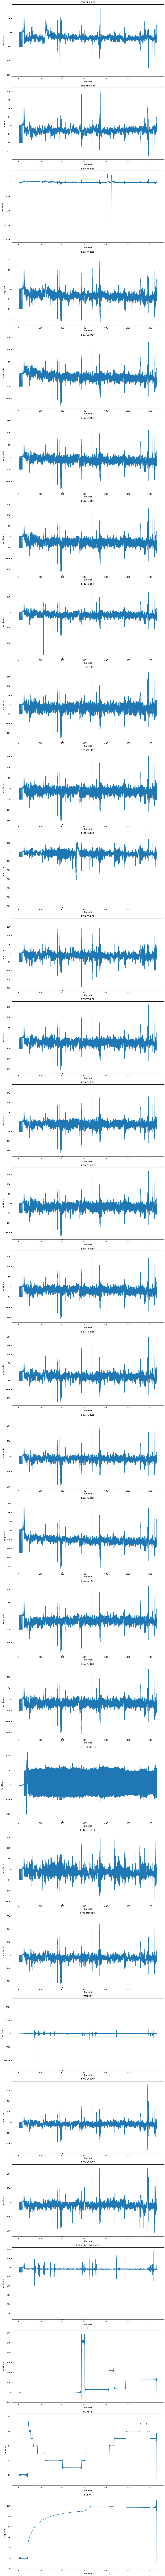

In [1]:
import pyedflib
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import resample

# 打开EDF文件
edf_file = pyedflib.EdfReader('/data/guihaokun/project/tuh_eeg/v2.0.0/edf/000/aaaaaaaa/s001_2015_12_30/01_tcp_ar/aaaaaaaa_s001_t000.edf')  


# 获取通道信息和数据
channel_labels = edf_file.getSignalLabels()
num_channels = len(channel_labels)
original_sample_rate = [edf_file.getSampleFrequency(i) for i in range(num_channels)]

# 读取原始数据
eeg_data = [edf_file.readSignal(i) for i in range(num_channels)]

# 关闭EDF文件
edf_file.close()

# 计算目标采样点数量
target_sample_rate = 200
num_samples_target = int(len(eeg_data[0]) * target_sample_rate / original_sample_rate[0])

# 重新采样到目标频率
eeg_data_resampled = np.zeros((num_channels, num_samples_target))
for i in range(num_channels):
    eeg_data_resampled[i, :] = resample(eeg_data[i], num_samples_target)

# 设置时间轴
time_resampled = np.arange(0, num_samples_target) / target_sample_rate

# 绘制每个通道的数据
plt.figure(figsize=(12, 6 * num_channels))
for i in range(num_channels):
    plt.subplot(num_channels, 1, i+1)
    plt.plot(time_resampled, eeg_data_resampled[i])
    plt.title(channel_labels[i])
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

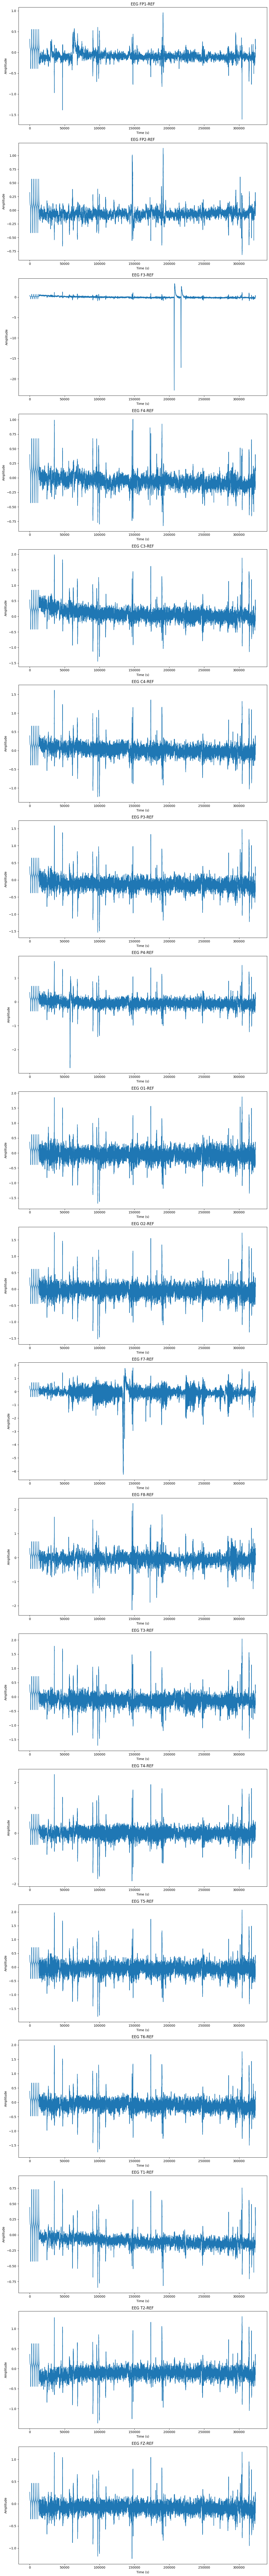

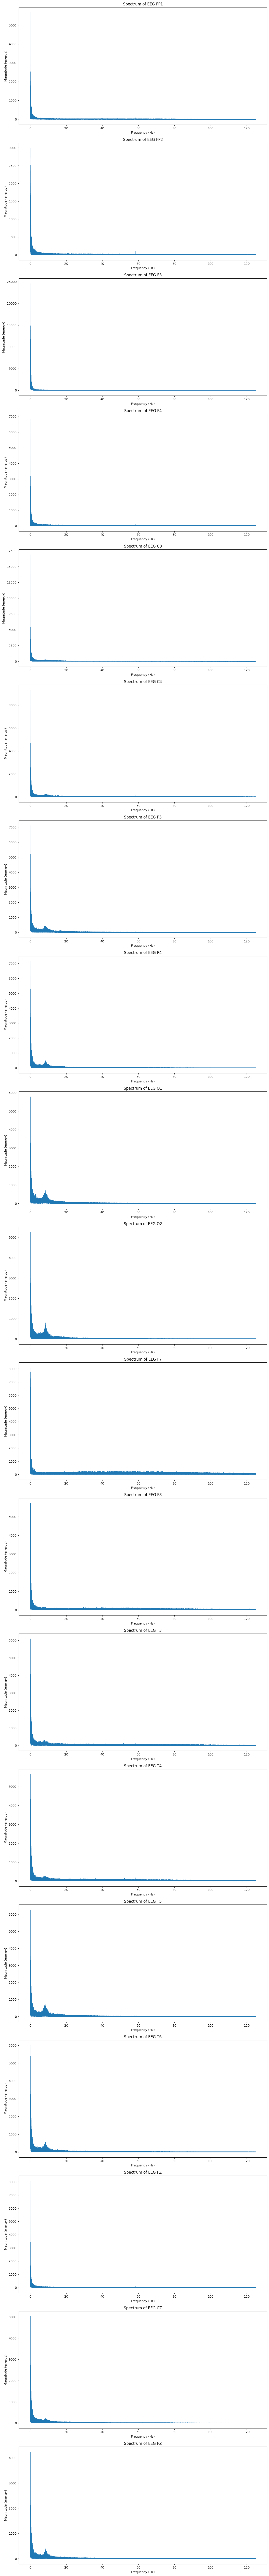

In [1]:
import pyedflib
import numpy as np
import matplotlib.pyplot as plt
import pickle
file_name = '/data/guihaokun/project/tuh_eeg/v2.0.0/edf/000/aaaaaaaa/s001_2015_12_30/01_tcp_ar/aaaaaaaa_s001_t000.edf'

def getOrderedChannels(file_name, verbose, labels_object, channel_names):
    labels = list(labels_object)
    for i in range(len(labels)):
        labels[i] = labels[i].split("-")[0]

    ordered_channels = []
    for ch in channel_names:
        try:
            ordered_channels.append(labels.index(ch))
        except:
            if verbose:
                print(file_name + " failed to get channel " + ch)
            raise Exception("channel not match")
    return ordered_channels

INCLUDED_CHANNELS = [
    'EEG FP1',
    'EEG FP2',
    'EEG F3',
    'EEG F4',
    'EEG C3',
    'EEG C4',
    'EEG P3',
    'EEG P4',
    'EEG O1',
    'EEG O2',
    'EEG F7',
    'EEG F8',
    'EEG T3',
    'EEG T4',
    'EEG T5',
    'EEG T6',
    'EEG FZ',
    'EEG CZ',
    'EEG PZ']

# 打开EEG文件并读取数据
with pyedflib.EdfReader(file_name) as edf_file:
    channel_labels = edf_file.getSignalLabels()
    num_channels = len(channel_labels)
    original_sample_rate = [edf_file.getSampleFrequency(i) for i in range(num_channels)]
    eeg_data = [edf_file.readSignal(i) for i in range(num_channels)]
    
max_inner_dim = max(len(row) for row in eeg_data)
eeg_data = np.array([np.pad(row, (0, max_inner_dim - len(row)), 'constant') for row in eeg_data])

orderedChannels = getOrderedChannels(
    file_name, False, channel_labels, INCLUDED_CHANNELS
)
eeg_data = eeg_data[orderedChannels, :]
num_channels = len(INCLUDED_CHANNELS)

means_dir = "/home/guihaokun/Time-Series-Pretrain/data/means_seq2seq_nofft.pkl"
stds_dir = "/home/guihaokun/Time-Series-Pretrain/data/stds_seq2seq_nofft.pkl"
with open(means_dir, "rb") as f:
    means = pickle.load(f).reshape(-1, 1)
with open(stds_dir, "rb") as f:
    stds = pickle.load(f).reshape(-1, 1)
eeg_data = (eeg_data - means) / stds

plt.figure(figsize=(12, 6 * num_channels))
for i in range(num_channels):
    plt.subplot(num_channels, 1, i+1)
    plt.plot(eeg_data[i])
    plt.title(channel_labels[i])
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

# Perform FFT
fft_result = np.fft.rfft(eeg_data, axis=-1)[:, 1:]
freqs = np.fft.rfftfreq(len(eeg_data[0]), 1/250)[1:]

# Compute the magnitude spectrum
magnitude_spectrum = np.abs(fft_result)

# 绘制每个通道的频谱图
plt.figure(figsize=(12, 6 * num_channels))
for i in range(num_channels):
    plt.subplot(num_channels, 1, i+1)
    plt.plot(freqs, magnitude_spectrum[i])
    # plt.magnitude_spectrum(eeg_data[i], Fs=original_sample_rate[i], scale='linear', color='b')
    plt.title(f"Spectrum of {INCLUDED_CHANNELS[i]}")
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude (energy)')

plt.tight_layout()
plt.show()


rate of devSet is 0.096711664935964
rate of evalSet is 0.10564304461942257
rate of trainSet is 0.0830504858511608


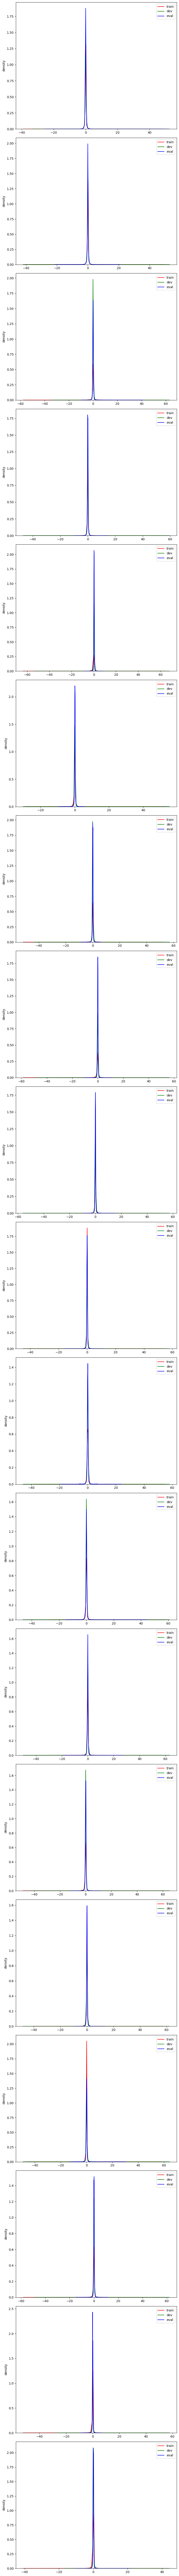

In [1]:
import numpy as np
import os
np.random.seed(7)

marker_dir = "/home/guihaokun/Time-Series-Pretrain/data"
anomaly_detection_dir = os.path.join(marker_dir,'file_markers_anomaly_detection')
root_dir = "/data/guihaokun/resample/tuh_eeg_serizure/"

splits = ['dev', 'eval', 'train']
sample_num = 40
num_channels = 19
data_dict = {}

for split in splits:
    file_name_sz = os.path.join(anomaly_detection_dir, f'{split}Set_seq2seq_60s_sz.txt')
    file_name_nosz = os.path.join(anomaly_detection_dir, f'{split}Set_seq2seq_60s_nosz.txt')
    with open(file_name_sz, 'r') as f:
        f_sz = f.readlines()
    with open(file_name_nosz, 'r') as f:
        f_nosz = f.readlines()
    rate = len(f_sz) / (len(f_nosz) + len(f_sz))
    print(f'rate of {split}Set is {rate}')

    for i in range(len(f_sz)):
        f_sz[i] = f_sz[i].strip('\n').split('.edf')[0] + '.h5'
    for i in range(len(f_nosz)):
        f_nosz[i] = f_nosz[i].strip('\n').split('.edf')[0] + '.h5'
    f_sz = np.unique(f_sz).tolist()
    f_nosz = np.unique(f_nosz).tolist()

    # sample
    f_all = f_sz + f_nosz
    np.random.shuffle(f_all)
    f_sample = f_all[:sample_num]
    data_dict[split] = f_sample

# visualize
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
dict = {}
with open(os.path.join(marker_dir, 'means_seq2seq_nofft.pkl'), 'rb') as f:
    means = pickle.load(f).reshape(-1, 1)
with open(os.path.join(marker_dir, 'stds_seq2seq_nofft.pkl'), 'rb') as f:
    stds = pickle.load(f).reshape(-1, 1)

for split in splits:
    signals = []
    for file_name in data_dict[split]:
        file_path = os.path.join(root_dir, file_name)
        with h5py.File(file_path, 'r') as f:
            signal = f["resample_signal"][()]
        signal = (signal.copy() - means) / stds
        signals.append(signal.copy())
    signals = np.concatenate(signals, axis=1)
    dict[split] = signals

# 绘制每个通道的数据
plt.figure(figsize=(8, 6 * num_channels))
for i in range(num_channels):
    plt.subplot(num_channels, 1, i+1)
    sns.kdeplot(dict['train'][i], color='r', label='train')
    sns.kdeplot(dict['dev'][i], color='g', label='dev')
    sns.kdeplot(dict['eval'][i], color='b', label='eval')
    plt.ylabel('density')
    plt.legend()
plt.tight_layout()
plt.show()

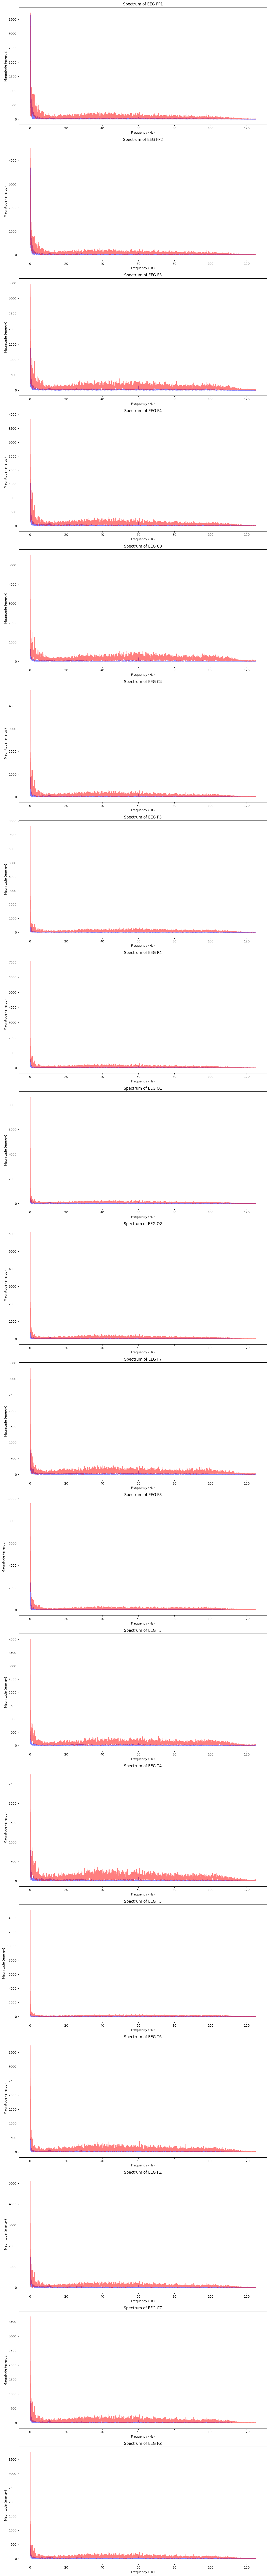

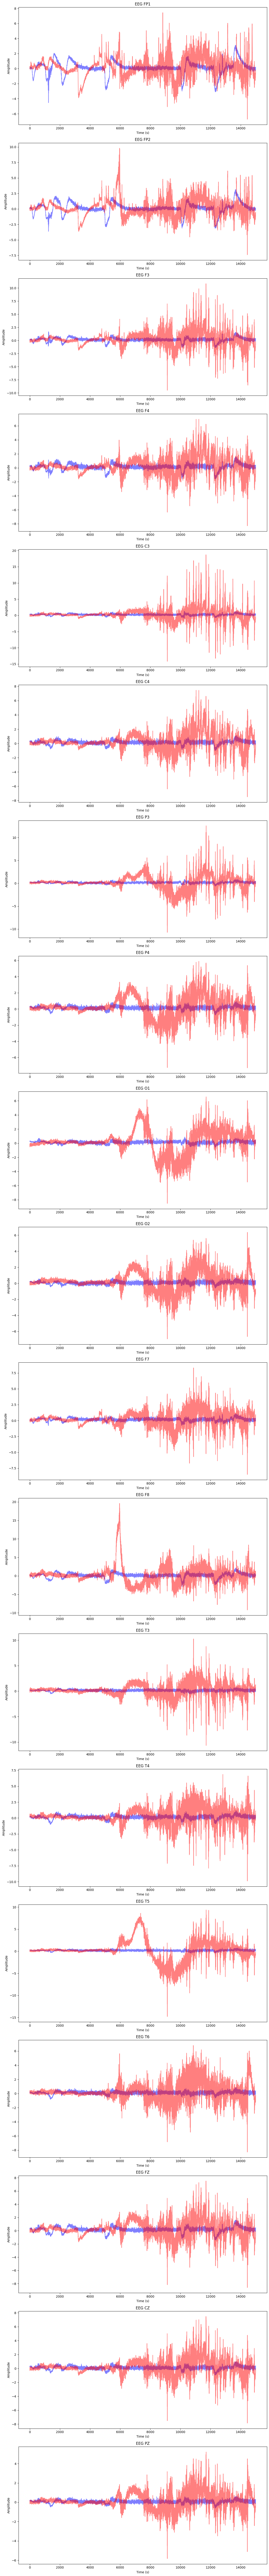

In [34]:
import numpy as np
import os
import re
import h5py
import pickle
from typing import Tuple
import matplotlib.pyplot as plt
root_dir = "/data/guihaokun/resample/tuh_eeg_serizure/"
INCLUDED_CHANNELS = [
    'EEG FP1',
    'EEG FP2',
    'EEG F3',
    'EEG F4',
    'EEG C3',
    'EEG C4',
    'EEG P3',
    'EEG P4',
    'EEG O1',
    'EEG O2',
    'EEG F7',
    'EEG F8',
    'EEG T3',
    'EEG T4',
    'EEG T5',
    'EEG T6',
    'EEG FZ',
    'EEG CZ',
    'EEG PZ']

def plot_sample(file_names: Tuple[str], mode: str='spectral'):

    means = pickle.load(open('/home/guihaokun/Time-Series-Pretrain/data/means_seq2seq_nofft.pkl', 'rb')).reshape(-1, 1)
    stds = pickle.load(open('/home/guihaokun/Time-Series-Pretrain/data/stds_seq2seq_nofft.pkl', 'rb')).reshape(-1, 1)

    signals = []
    for file_name in file_names:
        match = re.search(r'(\d+)\.h5', file_name)
        split = int(match.group(1))

        file_name = file_name.split('.edf')[0] + '.h5'        
        file_path = os.path.join(root_dir, file_name)
        with h5py.File(file_path, 'r') as f:
            signal = f["resample_signal"][()]
            start_window = split * 60 * 250
            end_window = start_window + 60 * 250
            signal = signal[:, start_window:end_window]
            num_channels = signal.shape[0]
        signal = (signal.copy() - means) / stds
        signals.append(signal.copy())
    if mode == 'temporal':
        plt.figure(figsize=(12, 6 * num_channels))
        for i in range(num_channels):
            plt.subplot(num_channels, 1, i+1)
            plt.plot(signals[0][i], color='b', alpha=0.5)
            plt.plot(signals[1][i], color='r', alpha=0.5)
            plt.title(f"{INCLUDED_CHANNELS[i]}")
            plt.xlabel('Time (s)')
            plt.ylabel('Amplitude')
        plt.tight_layout()
        plt.show()
    elif mode == 'spectral':
        fft_results = []
        freqs = []
        magnitude_spectrums = []
        for signal in signals:
            # Perform FFT
            fft_result = np.fft.rfft(signal, axis=-1)[:, 1:]
            freq = np.fft.rfftfreq(len(signal[0]), 1/250)[1:]
            magnitude_spectrum = np.abs(fft_result)
            magnitude_spectrums.append(magnitude_spectrum)
            fft_results.append(fft_result)
            freqs.append(freq)

        # Draw the magnitude spectrum
        plt.figure(figsize=(12, 6 * num_channels))
        for i in range(num_channels):
            plt.subplot(num_channels, 1, i+1)
            plt.plot(freqs[0], magnitude_spectrums[0][i], color='b', alpha=0.5)
            plt.plot(freqs[1], magnitude_spectrums[1][i], color='r', alpha=0.5)
            plt.title(f"Spectrum of {INCLUDED_CHANNELS[i]}")
            plt.xlabel('Frequency (Hz)')
            plt.ylabel('Magnitude (energy)')

        plt.tight_layout()
        plt.show()
    else:
        raise NotImplementedError   

plot_sample(("aaaaamtj_s001_t000.edf_4.h5, 0",
             "aaaaamtj_s001_t000.edf_19.h5, 1"), 
             mode='spectral')
plot_sample(("aaaaamtj_s001_t000.edf_4.h5, 0",
             "aaaaamtj_s001_t000.edf_19.h5, 1"), 
             mode='temporal')

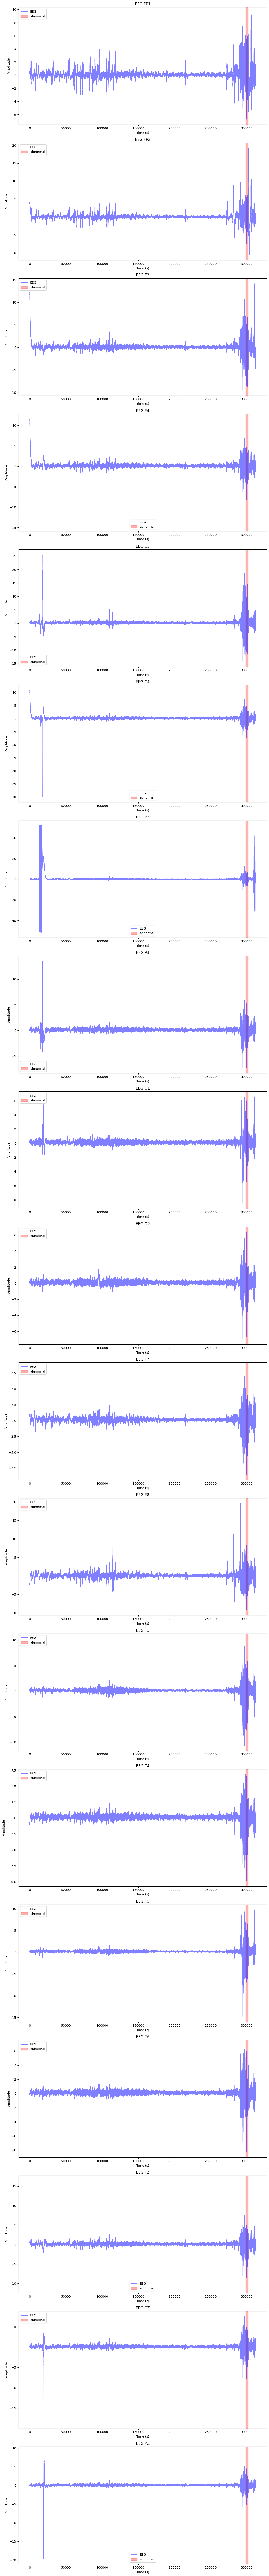

In [32]:
import numpy as np
import os
import re
import h5py
import pickle
import pandas as pd
import matplotlib.pyplot as plt
root_dir = "/data/guihaokun/resample/tuh_eeg_serizure/"

INCLUDED_CHANNELS = [
    'EEG FP1',
    'EEG FP2',
    'EEG F3',
    'EEG F4',
    'EEG C3',
    'EEG C4',
    'EEG P3',
    'EEG P4',
    'EEG O1',
    'EEG O2',
    'EEG F7',
    'EEG F8',
    'EEG T3',
    'EEG T4',
    'EEG T5',
    'EEG T6',
    'EEG FZ',
    'EEG CZ',
    'EEG PZ']

def plot_sample(file_name: str, mode: str='train'):
    directory = "/data/guihaokun/project/tuh_eeg_seizure/v2.0.0/edf"

    means = pickle.load(open('/home/guihaokun/Time-Series-Pretrain/data/means_seq2seq_nofft.pkl', 'rb')).reshape(-1, 1)
    stds = pickle.load(open('/home/guihaokun/Time-Series-Pretrain/data/stds_seq2seq_nofft.pkl', 'rb')).reshape(-1, 1)

    file_name = file_name.split('.edf')[0] + '.h5'        
    file_path = os.path.join(root_dir, file_name)
    with h5py.File(file_path, 'r') as f:
        signal = f["resample_signal"][()]
        num_channels = signal.shape[0]
    signal = (signal.copy() - means) / stds

    # Get the start_time and stop_time
    csv_file_name = file_name.split('.h5')[0] + '.csv_bi'
    # Find the csv file in the directory
    directory = os.path.join(directory, mode, csv_file_name.split('_')[0])
    files = os.listdir(directory)
    for file in files:
        if csv_file_name.split('_')[1] in file:
            directory = os.path.join(directory, file)
            break
    directory = os.path.join(directory, "01_tcp_ar", csv_file_name)
    seizure_time = []
    with open(directory) as f:
        for line in f.readlines():
            if "seiz" in line:
                seizure_time.append(
                    [
                        float(line.strip().split(',')[1]),
                        float(line.strip().split(',')[2])
                    ]
                )
    
    plt.figure(figsize=(12, 6 * num_channels))
    for i in range(num_channels):
        plt.subplot(num_channels, 1, i+1)
        plt.plot(signal[i], color='b', alpha=0.5, label='EEG')
        for interval in seizure_time:
            plt.axvspan(interval[0]*250, interval[1]*250, color='red', alpha=0.3, label='abnormal')
        plt.title(f"{INCLUDED_CHANNELS[i]}")
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        plt.legend()
    plt.tight_layout()
    plt.show()

plot_sample("aaaaamtj_s001_t000.edf_19.h5, 1")

33.19920000000002 599.0 3731.023 1.8506


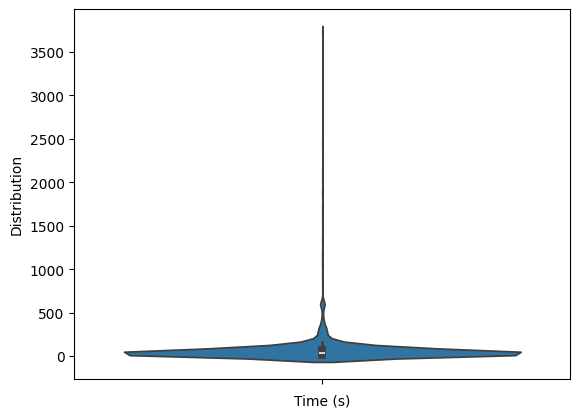

In [45]:
from typing import List
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import os

def get_seiz_inter(root_dir:str):
    inter = []
    for path, dir, files in os.walk(root_dir):
        for file in files:
            if file.endswith('.csv_bi'):
                file_path = os.path.join(path, file)
                with open(file_path, 'r') as f:
                    lines = f.readlines()
                for line in lines:
                    if "seiz" in line:
                        time = float(line.strip().split(',')[2]) - float(line.strip().split(',')[1])
                        if time > 0:
                            inter.append(time)
    return inter

def plot_distribution(inter: List[float]):
    sns.violinplot(inter)
    plt.xlabel('Time (s)')
    plt.ylabel('Distribution')

inter = get_seiz_inter("/data/guihaokun/project/tuh_eeg_seizure/v2.0.0/edf/train")
plot_distribution(inter)
print(statistics.median(inter), statistics.mode(inter), max(inter), min(inter))